
## Кластеризация Новостей

### <b><span style='color:#686dec'>Наша Задача</span></b>

Рассмотрим пример кластеризации текстов на стандартном наборе данных, новостях, выберем в наборе **4 из 20 категорий**

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

### <b><span style='color:#686dec'>Скачиваем данные</span></b>

Используя `fetch_20newsgroups`, воспользуемся только 4 классами 

In [47]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target
labels[:10]

3903 документов
4 категории


array([1, 1, 2, 2, 2, 3, 3, 2, 0, 2])

### <b><span style='color:#686dec'>Токенизация</span></b>

Тексты новостей нужно **преобразовать в числа** и почистить от посторонних символов. Для этого воспользуемся инструментом из библиотеки sklearn, он построит `токенизированные` данные

> Примечание: Токенизация — это разделение текста на компоненты. Например, токенизация по предложениям — это процесс разделения письменного языка на предложения-компоненты. А токенизация по словам — это разделение предложений на слова-компоненты.

In [48]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# Первые 10 слов первого документа
docs[0][:10]

['c5ff',
 'jupiter',
 'sun',
 'csd',
 'unb',
 'ca',
 'cook',
 'charlie',
 'subject',
 'nhl']

### <b><span style='color:#686dec'>Векторизация Слов</span></b>

- Каждый текст превратился в отдельный набор слов. 
- Перейдём к векторизации текстов: воспользуемся моделью Word2Vec, которая для каждого слова строит числовой вектор, в нашем случае каждое слово будет кодироваться 50 числами. 
- При этом вектора будем делать для тех слов, которые встречаются больше 20 раз во всех текстах документов. 
- Также сделаем средний вектор для всех слов, таким образом получим вектор для текста в целом.

In [49]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            # pass if word is not found
            pass
     
    return np.asarray(doc_vector) / num_words

X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))
    
print(f'Sentences: {len(X)}')
print(f'Each sentence has {X[0].shape} dimensions')

Sentences: 3903
Each sentence has (50,) dimensions


In [50]:
X[0]

array([-1.58635736e+00,  1.63898841e-01,  8.08457077e-01,  1.00274825e+00,
        2.41569087e-01, -1.22120626e-01,  1.00032461e+00,  7.58375943e-01,
       -8.77375901e-01, -1.50272891e-01,  9.70111862e-02, -8.17403615e-01,
       -4.17878687e-01,  2.04743981e-01,  2.33034179e-01, -4.36471403e-02,
       -2.71623224e-01,  4.84225806e-03, -1.14730798e-01, -4.46125358e-01,
       -1.83330595e-01, -1.27363995e-01,  1.00556612e+00, -7.95672178e-01,
        2.74445832e-01,  3.66903514e-01, -8.54147792e-01, -1.98808476e-01,
       -2.93522835e-01, -7.79545486e-01, -8.95587206e-02,  1.49794325e-01,
        4.46273059e-01,  5.50577581e-01, -1.22709799e+00, -8.10710043e-02,
       -2.80248135e-01, -1.90826192e-01,  6.40392661e-01, -8.74473095e-01,
        7.35989451e-01, -3.69897068e-01, -5.24353564e-01,  1.53910264e-03,
        3.04219544e-01,  3.05280328e-01, -4.45715249e-01, -8.36181343e-01,
       -1.15008622e-01, -7.36768246e-02], dtype=float32)

### <b><span style='color:#686dec'>Уменьшения Размерности</span></b>

Наша кластеризация будет работать лучше, если снизить размерность, для этого воспользуемся методом `TSNE`

> Примечание: `TSNE` — это техника нелинейного снижения размерности и визуализации многомерных признаков, почитать о ней можно, например, здесь.

При понижении размерности мы сохраняем близость элементов, то есть если элементы были близки при `vector_size=50`, то они останутся близки и при `vector_size=2`



In [51]:
import warnings; warnings.filterwarnings('ignore')

# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X = tsne.fit_transform(X)

### <b><span style='color:#686dec'>Кластеризация</span></b>

Создадим кластеризатор `KMeans` и обучим на подготовленных данных. Мы можем посмотреть получившиеся центроиды и предсказанные кластеры.

In [52]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучаем кластеризатор на подготовленных данных
kmeans.fit(X)

# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(np.int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[ -6.8084016   46.407467  ]
 [ -5.7084146  -37.110226  ]
 [-39.812744    -0.33722958]
 [ 53.020237     1.1617556 ]]


### <b><span style='color:#686dec'>Оценка Кластеров</span></b>

Посмотрим что мы получили и сравним с истиными метаками


`Коэффициент силуэта`, `однородность`, `полнота` и `V-мера` говорят о том, что кластеры довольно цельные, высокие совпадения между истинными значениями и результатов кластеризации

In [59]:
print ("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("completeness: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-meaure: %0.3f" % metrics.v_measure_score(labels, y_pred))

Silhouette Coefficient: 0.510
Homogeneity: 0.768
completeness: 0.771
V-meaure: 0.770


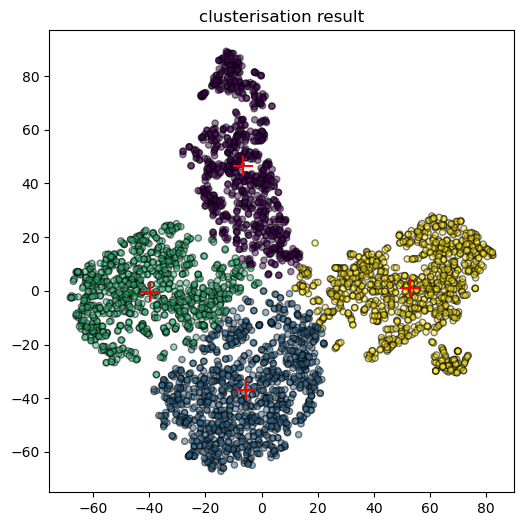

In [75]:
# Графики полученных кластеров

plt.rcParams['figure.figsize'] = 6,6
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20,ec='k',alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.title('clusterisation result')
plt.show()

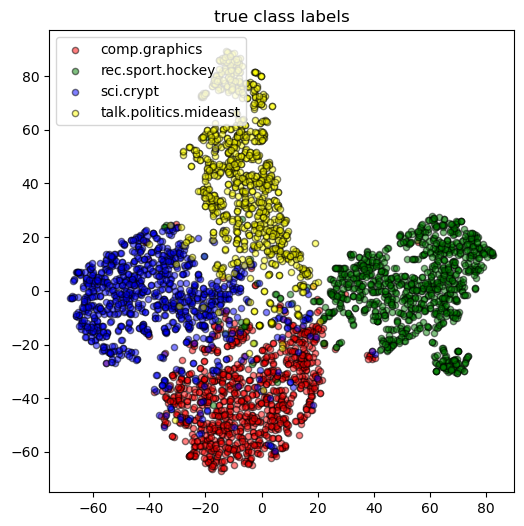

In [76]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=20, alpha=.5, ec='k', c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.title('true class labels')
plt.show()